In [1]:
# (c) Charles Le Losq 2021
# see embedded licence file

# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())
      
device = 'cpu'
print(device)

import imelt

# scaling coefficients for loss function
# viscosity is always one
# scaling coefficients for loss function
# viscosity is always one
ls = imelt.loss_scales()        
entro_scale = ls.entro
raman_scale = ls.raman
density_scale = ls.density
ri_scale = ls.ri
tg_scale = ls.tg

CUDA AVAILABLE?  True
cpu


# Size of dataset analysis

Here we trained 10 networks for each train dataset size.

We will select the best ones for each dataset size, and report the RMSE for viscosity for the training and validation reference data subset.

In [2]:
# Data import
prefix= ["0p10val","0p20val","0p30val","0p40val","0p50val","0p60val","0p70val","0p80val"]

suffix = ["_0","_1","_2","_3","_4","_5","_6","_7","_8","_9"]

# variable to record the results
total_size_train = np.zeros(len(prefix))
compo_size_train = np.zeros(len(prefix))
# order for errors is AG, MYEGA, A-M, CG, TVF, Raman, Density, Entropy, Refractivce Index
error_size_train = np.zeros((len(prefix),len(suffix),9))
error_size_valid = np.zeros((len(prefix),len(suffix),9))

# scaling coefficients
scaling = np.array([[1., 1., 1., 1., 1., raman_scale, density_scale, entro_scale, ri_scale]])
print(scaling.shape)

# Loading the reference dataset
ds = imelt.data_loader("./data/NKAS_viscosity_reference.hdf5",
                             "./data/NKAS_Raman.hdf5",
                             "./data/NKAS_density.hdf5",
                             "./data/NKAS_optical.hdf5",
                             device)

# Loss criterion
criterion = torch.nn.MSELoss()

for j in range(len(prefix)): # main loop: between datasets

    # Load the dataset used for training, to get the number of compositions
    dataset_name = "./data/NKAS_viscosity_{}.hdf5".format(prefix[j])
    ds_ = imelt.data_loader(dataset_name,
                             "./data/NKAS_Raman.hdf5",
                             "./data/NKAS_density.hdf5",
                             "./data/NKAS_optical.hdf5",
                             device)
    
    # saving in output variables
    total_size_train[j] = len(ds_.T_visco_train)
    compo_size_train[j] = np.unique(ds_.x_visco_train,axis=0).shape[0]
    
    for i in range(len(suffix)): # subloop: between each different training on one dataset
        
        # Loading the network and freezing dropout
        name_model = "model_l4_n200_p0_data{}{}.pth".format(prefix[j],suffix[i])
        neuralmodel = imelt.model(4,200,4,ds.nb_channels_raman,p_drop=0.01) 
        neuralmodel.load_state_dict(torch.load("./model/exp_trainsize/"+name_model, map_location='cpu'))
        neuralmodel.eval()
        
        # PREDICTIONS
        
        # PREDICTIONS
        with torch.set_grad_enabled(False):
    
            # train
            y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
            y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
            y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
            y_cg_pred_train = neuralmodel.cg(ds.x_visco_train,ds.T_visco_train)
            y_tvf_pred_train = neuralmodel.tvf(ds.x_visco_train,ds.T_visco_train)
            y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
            y_density_pred_train = neuralmodel.density(ds.x_density_train)
            y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)
            y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train, ds.lbd_ri_train)

            # valid
            y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
            y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
            y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
            y_cg_pred_valid = neuralmodel.cg(ds.x_visco_valid,ds.T_visco_valid)
            y_tvf_pred_valid = neuralmodel.tvf(ds.x_visco_valid,ds.T_visco_valid)
            y_raman_pred_valid = neuralmodel.raman_pred(ds.x_raman_valid)
            y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
            y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)
            y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid, ds.lbd_ri_valid)

            # Compute Loss

            # train 
            error_size_train[j,i,0]  = np.sqrt(criterion(y_ag_pred_train, ds.y_visco_train).item())
            error_size_train[j,i,1]  = np.sqrt(criterion(y_myega_pred_train, ds.y_visco_train).item())
            error_size_train[j,i,2]  = np.sqrt(criterion(y_am_pred_train, ds.y_visco_train).item())
            error_size_train[j,i,3]  = np.sqrt(criterion(y_raman_pred_train,ds.y_raman_train).item())
            error_size_train[j,i,4]  = np.sqrt(criterion(y_density_pred_train,ds.y_density_train).item())
            error_size_train[j,i,5]  = np.sqrt(criterion(y_entro_pred_train,ds.y_entro_train).item())

            # validation
            error_size_valid[j,i,0] = np.sqrt(criterion(y_ag_pred_valid, ds.y_visco_valid).item())
            error_size_valid[j,i,1] = np.sqrt(criterion(y_myega_pred_valid, ds.y_visco_valid).item())
            error_size_valid[j,i,2] = np.sqrt(criterion(y_am_pred_valid, ds.y_visco_valid).item())
            error_size_valid[j,i,3] = np.sqrt(criterion(y_raman_pred_valid,ds.y_raman_valid).item())
            error_size_valid[j,i,4] = np.sqrt(criterion(y_density_pred_valid,ds.y_density_valid).item())
            error_size_valid[j,i,5] = np.sqrt(criterion(y_entro_pred_valid,ds.y_entro_valid).item())

(1, 9)


# Architecture results

In [3]:
# List of networks
list_models = os.listdir("./model/exp_arch/")
nb_exp = len(list_models)

record_loss = pd.DataFrame()

record_loss["name"] = list_models

record_loss["nb_layers"] = np.zeros(nb_exp)
record_loss["nb_neurons"] = np.zeros(nb_exp)
record_loss["p_drop"] = np.zeros(nb_exp)

record_loss["loss_ag_train"] = np.zeros(nb_exp)
record_loss["loss_ag_valid"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)

record_loss["loss_cg_train"] = np.zeros(nb_exp)
record_loss["loss_cg_valid"] = np.zeros(nb_exp)

record_loss["loss_tvf_train"] = np.zeros(nb_exp)
record_loss["loss_tvf_valid"] = np.zeros(nb_exp)

record_loss["loss_Sconf_train"] = np.zeros(nb_exp)
record_loss["loss_Sconf_valid"] = np.zeros(nb_exp)

record_loss["loss_d_train"] = np.zeros(nb_exp)
record_loss["loss_d_valid"] = np.zeros(nb_exp)

record_loss["loss_raman_train"] = np.zeros(nb_exp)
record_loss["loss_raman_valid"] = np.zeros(nb_exp)

record_loss["loss_train"] = np.zeros(nb_exp)
record_loss["loss_valid"] = np.zeros(nb_exp)

### Load dataset

path_data = "./data/NKAS_viscosity_reference.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = imelt.data_loader(path_data,path_raman,path_density,path_optical,device)

# Loss criterion
criterion = torch.nn.MSELoss()

# Load dataset
for idx,name in enumerate(list_models):
    
    # Extract arch
    nb_layers = int(name[name.find("l")+1:name.find("_")])
    nb_neurons = int(name[name.find("n")+1:name.rfind("_")])
    p_drop = float(name[name.find("p")+1:name.rfind(".")])
    
    # Record arch
    record_loss.loc[idx,"nb_layers"] = nb_layers
    record_loss.loc[idx,"nb_neurons"] = nb_neurons
    record_loss.loc[idx,"p_drop"] = p_drop
    
    # Declare model
    neuralmodel = imelt.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
    neuralmodel.load_state_dict(torch.load("./model/exp_arch/"+name, map_location='cpu'))
    neuralmodel.eval()
    
    # PREDICTIONS
    with torch.set_grad_enabled(False):
        # train
        y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
        y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
        y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
        y_cg_pred_train = neuralmodel.cg(ds.x_visco_train,ds.T_visco_train)
        y_tvf_pred_train = neuralmodel.tvf(ds.x_visco_train,ds.T_visco_train)
        y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
        y_density_pred_train = neuralmodel.density(ds.x_density_train)
        y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)
        y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train, ds.lbd_ri_train)

        # valid
        y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
        y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
        y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
        y_cg_pred_valid = neuralmodel.cg(ds.x_visco_valid,ds.T_visco_valid)
        y_tvf_pred_valid = neuralmodel.tvf(ds.x_visco_valid,ds.T_visco_valid)
        y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
        y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)
        y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid, ds.lbd_ri_valid)

        # Compute Loss

        # train 
        record_loss.loc[idx,"loss_ag_train"] = np.sqrt(criterion(y_ag_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_myega_train"]  = np.sqrt(criterion(y_myega_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_am_train"]  = np.sqrt(criterion(y_am_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_cg_train"]  = np.sqrt(criterion(y_cg_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_tvf_train"]  = np.sqrt(criterion(y_tvf_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_raman_train"]  = np.sqrt(criterion(y_raman_pred_train,ds.y_raman_train).item())
        record_loss.loc[idx,"loss_d_train"]  = np.sqrt(criterion(y_density_pred_train,ds.y_density_train).item())
        record_loss.loc[idx,"loss_Sconf_train"]  = np.sqrt(criterion(y_entro_pred_train,ds.y_entro_train).item())
        record_loss.loc[idx,"loss_ri_train"]  = np.sqrt(criterion(y_ri_pred_train,ds.y_ri_train).item())

        # validation
        record_loss.loc[idx,"loss_ag_valid"] = np.sqrt(criterion(y_ag_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[idx,"loss_myega_valid"] = np.sqrt(criterion(y_myega_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[idx,"loss_am_valid"] = np.sqrt(criterion(y_am_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[idx,"loss_cg_valid"]  = np.sqrt(criterion(y_cg_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_tvf_valid"]  = np.sqrt(criterion(y_tvf_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_raman_valid"] = np.sqrt(criterion(y_raman_pred_valid,ds.y_raman_valid).item())
        record_loss.loc[idx,"loss_d_valid"] = np.sqrt(criterion(y_density_pred_valid,ds.y_density_valid).item())
        record_loss.loc[idx,"loss_Sconf_valid"] = np.sqrt(criterion(y_entro_pred_valid,ds.y_entro_valid).item())
        record_loss.loc[idx,"loss_ri_valid"]  = np.sqrt(criterion(y_ri_pred_valid,ds.y_ri_valid).item())
    
    record_loss.loc[idx,"loss_train"] = (record_loss.loc[idx,"loss_ag_train"] + 
                                         record_loss.loc[idx,"loss_myega_train"] + 
                                         record_loss.loc[idx,"loss_am_train"] + 
                                         record_loss.loc[idx,"loss_cg_train"] + 
                                         record_loss.loc[idx,"loss_tvf_train"] + 
                                         raman_scale*record_loss.loc[idx,"loss_raman_train"] + 
                                         density_scale*record_loss.loc[idx,"loss_d_train"] + 
                                         entro_scale*record_loss.loc[idx,"loss_Sconf_train"] + 
                                         ri_scale*record_loss.loc[idx,"loss_ri_train"])
    
    record_loss.loc[idx,"loss_valid"] = (record_loss.loc[idx,"loss_ag_valid"] + 
                                         record_loss.loc[idx,"loss_myega_valid"] + 
                                         record_loss.loc[idx,"loss_am_valid"] + 
                                         record_loss.loc[idx,"loss_cg_valid"] + 
                                         record_loss.loc[idx,"loss_tvf_valid"] + 
                                         raman_scale*record_loss.loc[idx,"loss_raman_valid"] + 
                                         density_scale*record_loss.loc[idx,"loss_d_valid"] + 
                                         entro_scale*record_loss.loc[idx,"loss_Sconf_valid"] + 
                                         ri_scale*record_loss.loc[idx,"loss_ri_valid"])

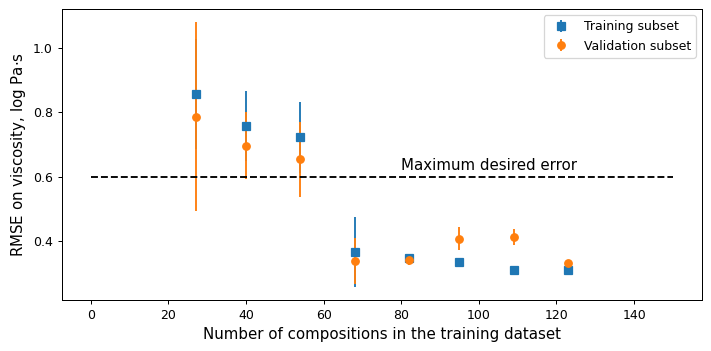

In [11]:
plt.figure(figsize=(8,4), dpi=90)
plt.errorbar(compo_size_train, 
             np.median(error_size_train[:,:,1], axis=1),
             yerr=np.std(error_size_train[:,:,1], axis=1),fmt="s", color="C0", label="Training subset")
plt.errorbar(compo_size_train, 
             np.median(error_size_valid[:,:,1], axis=1),
             yerr=np.std(error_size_valid[:,:,1], axis=1),fmt="o", color="C1", label = "Validation subset")
plt.plot([0,150],[0.6,0.6],"k--")
plt.annotate("Maximum desired error", xy=(80, 0.62), fontsize=12)
plt.legend(loc="best")
plt.xlabel("Number of compositions in the training dataset", fontsize=12)
plt.ylabel("RMSE on viscosity, log Pa$\cdot$s", fontsize=12)
plt.tight_layout()
plt.savefig("./manuscript/dev/Data_size.png")

cpu
Using the equation from Adam-Gibbs:
    RMSE on the full range (0-15 log Pa s): train 0.3, valid 0.3, test 0.4
    RMSE on the -inf - 7.0 log Pa s range: train 0.2, valid 0.2, test 0.2
    RMSE on the 7.0 - +inf log Pa s range: train 0.3, valid 0.5, test 0.6

Using the equation from Free Volume:
    RMSE on the full range (0-15 log Pa s): train 0.3, valid 0.4, test 0.4
    RMSE on the -inf - 7.0 log Pa s range: train 0.2, valid 0.1, test 0.2
    RMSE on the 7.0 - +inf log Pa s range: train 0.3, valid 0.7, test 0.5

Using the equation from Vogel Fulcher Tamman:
    RMSE on the full range (0-15 log Pa s): train 0.3, valid 0.4, test 0.4
    RMSE on the -inf - 7.0 log Pa s range: train 0.3, valid 0.2, test 0.3
    RMSE on the 7.0 - +inf log Pa s range: train 0.3, valid 0.6, test 0.5

Using the equation from Avramov Milchev:
    RMSE on the full range (0-15 log Pa s): train 0.3, valid 0.4, test 0.4
    RMSE on the -inf - 7.0 log Pa s range: train 0.2, valid 0.2, test 0.2
    RMSE on the

/tmp/ipykernel_148020/3507464514.py:102: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(ds.y_visco_train,y_ag_train)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

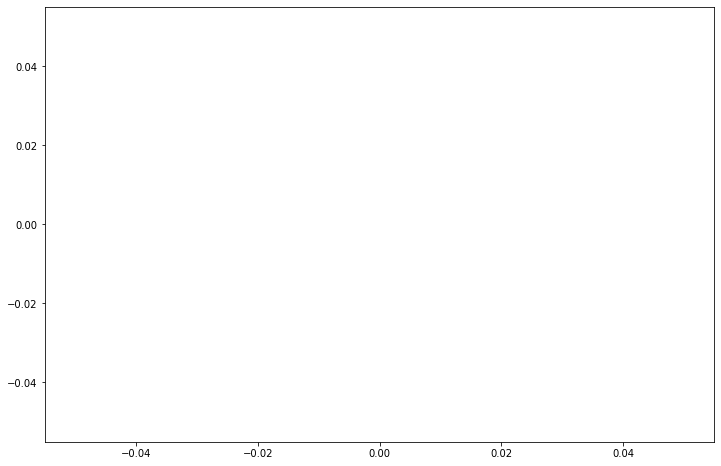

In [14]:
# (c) Charles Le Losq 2021
# see embedded licence file

%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np
import seaborn as sns

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import ArrowStyle, FancyArrowPatch
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# spearman corr coef
from scipy.stats import spearmanr

# mse
from sklearn.metrics import mean_squared_error

# imelt internals
import imelt

# other essentials
import torch, time, h5py

# we will work on CPU there
device = torch.device('cpu') #get_default_device()
print(device)

path_data = "./data/NKAS_viscosity_reference.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = imelt.data_loader(path_data,path_raman,path_density,path_optical,device)

path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]

neuralmodel = imelt.bagging_models(path, name_list, ds, device)

RMSE_ag_tot, RMSE_ag_low, RMSE_ag_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='ag', boundary=7)
RMSE_cg_tot, RMSE_cg_low, RMSE_cg_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='cg', boundary=7)
RMSE_tvf_tot, RMSE_tvf_low, RMSE_tvf_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='tvf', boundary=7)
RMSE_am_tot, RMSE_am_low, RMSE_am_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='am', boundary=7)
RMSE_myega_tot, RMSE_myega_low, RMSE_myega_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='myega', boundary=7)

#
# Predictions for Raman spectra
#

# our real x axis, for resampling
x_raman_shift = np.arange(400.,1250.,1.0)

raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train).mean(axis=2)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid).mean(axis=2)

# Now we calculate on density and refractive index
ese_density_train = np.sqrt(mean_squared_error(ds.y_density_train.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_train).mean(axis=1)))
ese_density_valid = np.sqrt(mean_squared_error(ds.y_density_valid.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_valid).mean(axis=1)))
ese_density_test = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_test).mean(axis=1)))

ese_ri_train = np.sqrt(mean_squared_error(ds.y_ri_train.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_train,lbd=ds.lbd_ri_train).mean(axis=1)))
ese_ri_valid = np.sqrt(mean_squared_error(ds.y_ri_valid.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_valid,lbd=ds.lbd_ri_valid).mean(axis=1)))
ese_ri_test = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_test,lbd=ds.lbd_ri_test).mean(axis=1)))

print('RMSE density train after training {0:.3f}'.format(ese_density_train))
print('RMSE density valid after training {0:.2f}'.format(ese_density_valid))
print('RMSE density test after training {0:.2f}'.format(ese_density_test))
print('')

print('RMSE refractive train loss after training {0:.3f}'.format(ese_ri_train))
print('RMSE refractive valid loss after training {0:.3f}'.format(ese_ri_valid))
print('RMSE refractive test loss after training {0:.3f}'.format(ese_ri_test))
print('')

y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)



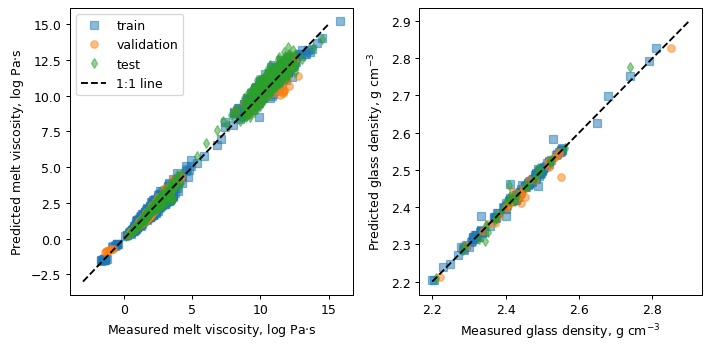

In [32]:

fig = plt.figure(figsize=(8,4), dpi=90)

plt.subplot(1,2,1)
plt.plot(ds.y_visco_train,y_ag_train.mean(axis=1),'s', alpha=0.5, label="train")
plt.plot(ds.y_visco_valid,y_ag_valid.mean(axis=1),'o', alpha=0.5, label="validation")
plt.plot(ds.y_visco_test,y_ag_test.mean(axis=1),'d', alpha=0.5, label="test")
plt.plot([-3,15],[-3,15], "k--", label="1:1 line")

plt.ylabel("Predicted melt viscosity, log Pa$\cdot$s")
plt.xlabel("Measured melt viscosity, log Pa$\cdot$s")

plt.legend()

plt.subplot(1,2,2)
plt.plot(ds.y_density_train,neuralmodel.predict("density",ds.x_density_train).mean(axis=1),'s', alpha=0.5, label="train")
plt.plot(ds.y_density_valid,neuralmodel.predict("density",ds.x_density_valid).mean(axis=1),'o', alpha=0.5, label="validation")
plt.plot(ds.y_density_test,neuralmodel.predict("density",ds.x_density_test).mean(axis=1),'d', alpha=0.5, label="test")
plt.plot([2.2,2.9],[2.2,2.9], "k--", label="1:1 line")

plt.ylabel("Predicted glass density, g cm$^{-3}$")
plt.xlabel("Measured glass density, g cm$^{-3}$")

plt.tight_layout()

plt.savefig("./manuscript/dev/visco_d_comp.png")